In [1]:
!pip install wget --quiet

  Preparing metadata (setup.py) ... done


In [2]:
!pip install --upgrade tensorflow==2.12.0 tensorflow_hub==0.13.0 --quiet

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py --quiet

In [4]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip" --quiet

In [5]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data

unzip_data("nlp_getting_started.zip")

In [6]:
# Importing TensorFlow and Keras libraries
import tensorflow as tf
from keras import Sequential
from keras.layers import Input, GlobalAveragePooling1D, Dense, LSTM, Conv1D, GlobalMaxPool1D
from keras.layers import TextVectorization, Embedding
from keras.optimizers import Adam
import tensorflow_hub as hub

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from helper_functions import make_confusion_matrix

In [7]:
class PreprocessData:

    def __init__(self):
        self.train_df = pd.read_csv('train.csv')
        self.test_df = pd.read_csv('test.csv')

        self.train_df_shuffled = self.train_df.sample(frac=1, random_state=42)

        self.train_sentences = None
        self.train_labels = None
        self.val_sentences = None
        self.val_labels = None

        self.max_vocab_length = 10000
        self.max_output_sequence_length = 15

    def get_train_val_data(self):
        self.train_sentences, self.val_sentences,\
            self.train_labels, self.val_labels = train_test_split(self.train_df_shuffled['text'].to_numpy(),
                                                                  self.train_df_shuffled['target'].to_numpy(),
                                                                  test_size=0.1,
                                                                  random_state=42)
        return self.train_sentences, self.train_labels, self.val_sentences, self.val_labels


In [8]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1-score of a binary classification model;
    :param y_true: true labels in the form of a 1D array;
    :param y_pred: predicted labels in the form of a 1D array;
    :return: a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1-score": model_f1}

    return model_results

In [9]:
# Initialize dataset for this file
preprocess_data = PreprocessData()

# Read train & validation sets of dataset data
train_splt_sentences, train_splt_labels, val_splt_sentences, val_splt_labels = preprocess_data.get_train_val_data()

# Define variable for embeddings
max_vocab_length = preprocess_data.max_vocab_length
max_output_length = preprocess_data.max_output_sequence_length

## Excerise - 5

In [10]:
# Create tokenization and modelling pipeline
ex_model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),  # convert words to numbers using tfidf
    ('clf', MultinomialNB())  # model for the text
])

In [11]:
# Fit the pipeline to the training data
ex_model_0.fit(train_splt_sentences, train_splt_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [12]:
# Make predictions
ex_baseline_preds = ex_model_0.predict(val_splt_sentences)

In [13]:
# Get baseline results
ex_baseline_results = calculate_results(y_true=val_splt_labels,
                                        y_pred=ex_baseline_preds)

In [14]:
# === Building Model 2 ===
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_output_length)

text_vectorizer.adapt(train_splt_sentences)

In [15]:
tf.random.set_seed(17)

# Building Embedding layer
ex_embedding_2 = Embedding(input_dim=max_vocab_length,
                            output_dim=128,
                            embeddings_initializer="uniform",
                            input_length=max_output_length,
                            name="ex_embedding_2")

In [16]:
# Building Sequential of model
ex_model_2 = Sequential([
    Input(shape=(1,), dtype="string"),
    text_vectorizer,
    ex_embedding_2,
    LSTM(64),
    Dense(1, activation="sigmoid")
])

In [17]:
# Compile the model
ex_model_2.compile(loss="binary_crossentropy",
                    optimizer=Adam(),
                    metrics=["accuracy"])

In [18]:
# Training the model
ex_model_2_history = ex_model_2.fit(train_splt_sentences,
                                    train_splt_labels,
                                    epochs=5,
                                    validation_data=(val_splt_sentences, val_splt_labels))

Epoch 1/5
215/215 [==============================] - 13s 17ms/step - loss: 0.5177 - accuracy: 0.7444 - val_loss: 0.4609 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3191 - accuracy: 0.8699 - val_loss: 0.4871 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2234 - accuracy: 0.9158 - val_loss: 0.6253 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1517 - accuracy: 0.9442 - val_loss: 0.7294 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1045 - accuracy: 0.9618 - val_loss: 0.8601 - val_accuracy: 0.7546


In [19]:
# Getting prediction probabilities
ex_model_2_pred_probs = ex_model_2.predict(val_splt_sentences)

# Convert probabilities to labels (numbers)
ex_model_2_preds = tf.squeeze(tf.round(ex_model_2_pred_probs))

# Calculate results of predictions (accuracy, precision, recall, f1-score)
ex_model_2_results = calculate_results(val_splt_labels, ex_model_2_preds)

24/24 [==============================] - 1s 3ms/step


In [20]:
#  === Building Model 6 (USE) ===
tf.random.set_seed(17)

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of input coming to our model
                                        dtype=tf.string,  # data type of input coming to the USE layer
                                        trainable=False,  # keep the pretrained weight
                                                            # (we'll create a feature extractor)
                                        name="USE")

In [21]:
# Create model using the Sequential API
ex_model_6 = Sequential([
    sentence_encoder_layer,
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
], name="model_6_USE")

In [22]:
# Compile model
ex_model_6.compile(loss="binary_crossentropy",
                    optimizer=Adam(),
                    metrics=["accuracy"])
# model_6.summary()

In [23]:
# Train a classifier on top of pretrained embeddings
ex_model_6_history = ex_model_6.fit(train_splt_sentences,
                                    train_splt_labels,
                                    epochs=5,
                                    validation_data=(val_splt_sentences, val_splt_labels),
                                    callbacks=[])

Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.5075 - accuracy: 0.7796 - val_loss: 0.4470 - val_accuracy: 0.8097
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4151 - accuracy: 0.8162 - val_loss: 0.4375 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4014 - accuracy: 0.8190 - val_loss: 0.4328 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3927 - accuracy: 0.8273 - val_loss: 0.4271 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3864 - accuracy: 0.8318 - val_loss: 0.4270 - val_accuracy: 0.8136


In [24]:
# Make predictions with USE TF Hub model
ex_model_6_pred_probs = ex_model_6.predict(val_splt_sentences)

# Convert prediction probabilities to labels
ex_model_6_preds = tf.squeeze(tf.round(ex_model_6_pred_probs))

# Calculate model 6 performance metrics
ex_model_6_results = calculate_results(val_splt_labels, ex_model_6_preds)

24/24 [==============================] - 1s 10ms/step


In [25]:
def majority_vote(ensemble_preds):
    """
    Takes predictions from all models and makes majority voted predictions
    for each sample;
    :param ensemble_preds: predictions from all models;
    :return: tensor with all majority voted preds.
    """
    y_preds = np.array([])
    for pred in ensemble_preds:
        y_pred, _, count = tf.unique_with_counts(pred)
        y_preds = np.concatenate([y_preds, [y_pred[tf.argmax(count).numpy()]]])
    return y_preds

In [26]:
# === Build ensemble model from 3 models (baseline, LSTM, USE) ===
# Get majority vote (mode) pred probs for 3 models
combined_preds = tf.concat([[ex_baseline_preds], [ex_model_2_preds], [ex_model_6_preds]], axis=0)
majority_voted_preds = majority_vote(zip(ex_baseline_preds, ex_model_2_preds, ex_model_6_preds))
print(majority_voted_preds)

[0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.

In [27]:
# Calculate results from majority vote (mode) of the prediction probabilities
ensemble_results = calculate_results(val_splt_labels, majority_voted_preds)

In [28]:
ensemble_results

{'accuracy': 80.18372703412074,
 'precision': 0.8108815326824119,
 'recall': 0.8018372703412073,
 'f1-score': 0.7981002711701818}

In [29]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": ex_baseline_results,
                                  # "simple_dense": model_1_results,
                                  "lstm": ex_model_2_results,
                                  "tf_hub_sentence_encoder": ex_model_6_results,
                                  "ensemble_results": ensemble_results})

# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["accuracy"] = all_model_results.loc["accuracy"]/100 

In [30]:
print("|=== All model results ==|")
print(all_model_results)

|=== All model results ==|
           baseline      lstm  tf_hub_sentence_encoder  ensemble_results
accuracy   0.792651  0.754593                 0.813648          0.801837
precision  0.811139  0.755280                 0.814169          0.810882
recall     0.792651  0.754593                 0.813648          0.801837
f1-score   0.786219  0.752702                 0.812791          0.798100


## Exercise - 6

Best model is 'tf_hub_sentence_encoder', then we visualise confusion matrix for it results.

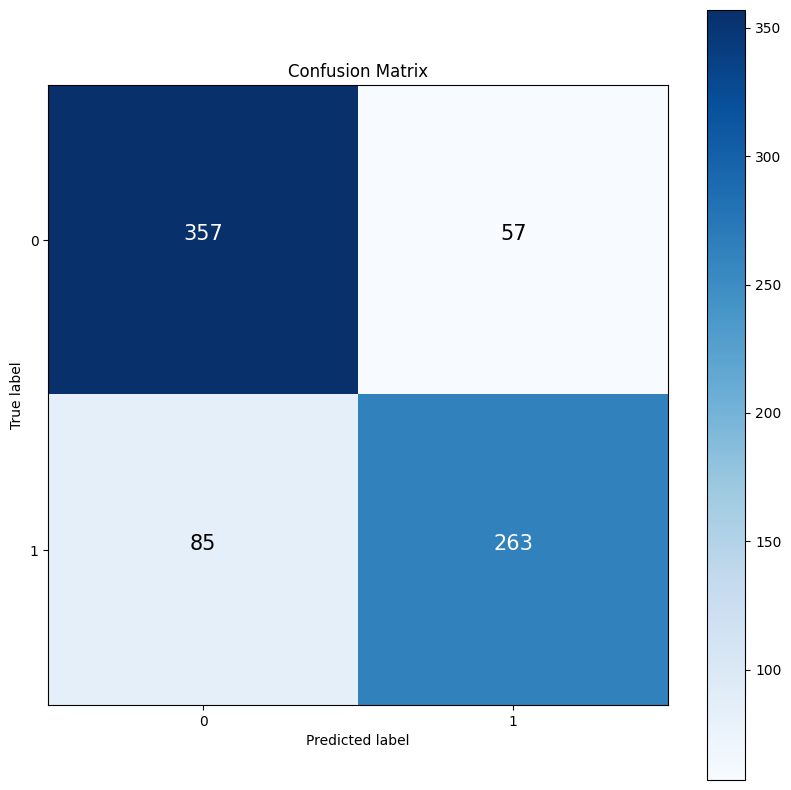

In [31]:
# Visualise confusion matrix for best model results
make_confusion_matrix(val_splt_labels, ex_model_6_preds)
plt.show()

## Conclusions
As a result, we received the best model with an accuracy level of 81.23%. And her confusion matrix has expected results.